In [1]:
!pip install nbimporter

In [2]:
import numpy as np
import tensorflow as tf
from time import time
import sys
from dataLoader import loadData
import os

In [3]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [5]:
seed = 47
np.random.seed(seed)

In [6]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.591748237609863 seconds
loaded dense data matrix


In [7]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [8]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [11]:
get_sparsity(tr)

4.021525859265269

In [12]:
get_sparsity(vr)

0.44683670296601535

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os

In [14]:
lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 0 #change
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-3 # constant for L2 penalty (diversity)

In [15]:
train = tr.copy()

In [16]:
if torch.cuda.is_available()==True:
    device="cuda"
else:
    device ="cpu"

In [17]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())/(fake == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD().to(device)
netG = NetG().to(device)
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [18]:
one = torch.FloatTensor([1]).to(device)
mone = (one * -1).to(device)

In [19]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [20]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [21]:
get_random_batch(train, batch_size=batch_size).shape

(64, 3706)

In [22]:
train = torch.autograd.Variable(torch.Tensor(train))

In [23]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [53]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
for epoch in range(0):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            torch.save(netG.state_dict(), './netG-1m')
            torch.save(netD.state_dict(), './netD-1m')
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

Epoch number 1. my distance between random real and fake samples 33754.09375
Epoch number 1. MSE distance between random real and fake samples 0.5465670824050903
Epoch number 3. my distance between random real and fake samples 33166.625
Epoch number 3. MSE distance between random real and fake samples 0.5593405365943909
Epoch number 5. my distance between random real and fake samples 43156.2890625
Epoch number 5. MSE distance between random real and fake samples 0.7913061380386353
Epoch number 7. my distance between random real and fake samples 38046.9609375
Epoch number 7. MSE distance between random real and fake samples 0.7794598340988159
Epoch number 9. my distance between random real and fake samples 46134.140625
Epoch number 9. MSE distance between random real and fake samples 0.992827832698822
Epoch number 11. my distance between random real and fake samples 50504.90625
Epoch number 11. MSE distance between random real and fake samples 1.0978482961654663
Epoch number 13. my dist

KeyboardInterrupt: 

In [25]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

In [26]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [27]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG(noisev)

In [28]:
fake.shape

torch.Size([6040, 3706])

In [29]:
fake = np.around(fake.detach().cpu().numpy())

In [30]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [31]:
fake = fake * (fake <= 5).astype(int)

In [32]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1745156 226310
4 611182 348971
3 89871 261197
2 2832 107557
1 1 56174
0 19935198 21384031


In [33]:
train > 3 

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [34]:
get_sparsity(train > 3)

8.934857739195076e-06

In [35]:
(train[0,:] > 3).sum()

tensor(43)

In [36]:
train

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])

In [37]:
train = torch.Tensor(tr.copy()).to(device)

In [38]:
get_sparsity(train.cpu().numpy())

4.021525859265269

In [39]:
train > 3

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [40]:
zero_mask = (train == 0).to(device).float()

In [41]:
positive_feedback_mask = (train > 3).to(device).float()

In [42]:
negative_feedback_mask = ((train < 4).to(device).float() * (1 - zero_mask)).to(device).float()

In [43]:
((positive_feedback_mask + negative_feedback_mask) != zero_mask).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

In [44]:
get_sparsity(negative_feedback_mask.cpu().numpy())

1.7090908603553212

TRAINING DENOISING AUTOENCODER ON NEGATIVE FEEDBACKS

In [73]:
class denoising_autoencoder(nn.Module):
    def __init__(self, input_size, z=16):
        super(denoising_autoencoder, self).__init__()
        self.encoder=nn.Sequential(
                      nn.Linear(input_size, 1024),
                      nn.ReLU(),
                      nn.Linear(1024,512),
                      nn.ReLU(),
                      nn.Linear(512, z),
                      nn.Sigmoid()
                      )

        self.decoder=nn.Sequential(
                      nn.Linear(z, 512),
                      nn.ReLU(),
                      nn.Linear(512, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, input_size),
#                       nn.Sigmoid(),
                      )
    
 
    def forward(self, x):
        z=self.encoder(x)
        x=self.decoder(z)
    
        return x

In [74]:
model = denoising_autoencoder(input_size=train[0,:].shape[0]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001, weight_decay=1e-4)

In [75]:
model

denoising_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3706, bias=True)
  )
)

In [76]:
def get_random_masked_batch(mat, batch_size = 32, p=0.5):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    return mat[rand_rows], torch.nn.Dropout()(mat[rand_rows]), rand_rows

orig, masked, _ = get_random_masked_batch(negative_feedback_mask)

In [77]:
get_sparsity(orig.cpu().numpy())

1.096195358877496

In [78]:
get_sparsity(masked.cpu().numpy())

0.5346060442525634

In [79]:
# torch.nn.functional.dropout(orig, training=False)

In [ ]:
epochs = 120
# l = len(trainloader)
l = 120
losslist = []
epochloss = 0
running_loss = 0
steps_per_epoch = 200

for epoch in range(epochs):
  
    print("Entering Epoch: ", epoch)
    for i in range(steps_per_epoch):
        orig, masked, _ = get_random_masked_batch(train)

        #-----------------Forward Pass----------------------
        output = model(masked)
        loss = criterion(output, orig)
        #-----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
        #-----------------Log-------------------------------
        losslist.append(running_loss/l)
        running_loss=0
#     print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
        print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

Entering Epoch:  0
======> epoch: 0/120, Loss:0.6651427745819092
======> epoch: 0/120, Loss:0.5505983233451843
======> epoch: 0/120, Loss:0.6779229640960693
======> epoch: 0/120, Loss:0.5391103625297546
======> epoch: 0/120, Loss:0.5956745743751526
======> epoch: 0/120, Loss:0.4802171587944031
======> epoch: 0/120, Loss:0.5821182727813721
======> epoch: 0/120, Loss:0.5942570567131042
======> epoch: 0/120, Loss:0.7994381189346313
======> epoch: 0/120, Loss:0.5757617354393005
======> epoch: 0/120, Loss:0.8329598903656006
======> epoch: 0/120, Loss:0.7018328905105591
======> epoch: 0/120, Loss:0.503227710723877
======> epoch: 0/120, Loss:0.5140268206596375
======> epoch: 0/120, Loss:0.6529934406280518
======> epoch: 0/120, Loss:0.48091909289360046
======> epoch: 0/120, Loss:0.46854183077812195
======> epoch: 0/120, Loss:0.6841725707054138
======> epoch: 0/120, Loss:0.5989440083503723
======> epoch: 0/120, Loss:0.4670373499393463
======> epoch: 0/120, Loss:0.39714691042900085
======> epoch

======> epoch: 0/120, Loss:0.4692714810371399
======> epoch: 0/120, Loss:0.45928728580474854
======> epoch: 0/120, Loss:0.4091404974460602
======> epoch: 0/120, Loss:0.5156059861183167
======> epoch: 0/120, Loss:0.6408821940422058
======> epoch: 0/120, Loss:0.33073490858078003
======> epoch: 0/120, Loss:0.3692307472229004
======> epoch: 0/120, Loss:0.5115244388580322
======> epoch: 0/120, Loss:0.6270338296890259
======> epoch: 0/120, Loss:0.5332348346710205
======> epoch: 0/120, Loss:0.3840417265892029
======> epoch: 0/120, Loss:0.6072338819503784
======> epoch: 0/120, Loss:0.5675384402275085
======> epoch: 0/120, Loss:0.6201466917991638
======> epoch: 0/120, Loss:0.5046980381011963
======> epoch: 0/120, Loss:0.49977055191993713
======> epoch: 0/120, Loss:0.48224711418151855
======> epoch: 0/120, Loss:0.4004890024662018
======> epoch: 0/120, Loss:0.41417741775512695
======> epoch: 0/120, Loss:0.48158884048461914
======> epoch: 0/120, Loss:0.37005355954170227
======> epoch: 0/120, Loss:

======> epoch: 1/120, Loss:0.5330417156219482
======> epoch: 1/120, Loss:0.48442021012306213
======> epoch: 1/120, Loss:0.5460541844367981
======> epoch: 1/120, Loss:0.5220346450805664
======> epoch: 1/120, Loss:0.4102003574371338
======> epoch: 1/120, Loss:0.4311358332633972
======> epoch: 1/120, Loss:0.4397321939468384
======> epoch: 1/120, Loss:0.45839226245880127
======> epoch: 1/120, Loss:0.46261247992515564
======> epoch: 1/120, Loss:0.4058316946029663
======> epoch: 1/120, Loss:0.41564857959747314
======> epoch: 1/120, Loss:0.5014026761054993
======> epoch: 1/120, Loss:0.5342391729354858
======> epoch: 1/120, Loss:0.6028380393981934
======> epoch: 1/120, Loss:0.42672690749168396
======> epoch: 1/120, Loss:0.40947628021240234
======> epoch: 1/120, Loss:0.46203118562698364
======> epoch: 1/120, Loss:0.49340200424194336
======> epoch: 1/120, Loss:0.5359365940093994
======> epoch: 1/120, Loss:0.5691115856170654
======> epoch: 1/120, Loss:0.518007218837738
======> epoch: 1/120, Loss:

======> epoch: 2/120, Loss:0.3901291489601135
======> epoch: 2/120, Loss:0.44744810461997986
======> epoch: 2/120, Loss:0.5730382204055786
======> epoch: 2/120, Loss:0.35858628153800964
======> epoch: 2/120, Loss:0.4514503479003906
======> epoch: 2/120, Loss:0.39749255776405334
======> epoch: 2/120, Loss:0.5407401919364929
======> epoch: 2/120, Loss:0.5605946779251099
======> epoch: 2/120, Loss:0.5466640591621399
======> epoch: 2/120, Loss:0.3566581606864929
======> epoch: 2/120, Loss:0.3484187126159668
======> epoch: 2/120, Loss:0.4145372807979584
======> epoch: 2/120, Loss:0.3301933705806732
======> epoch: 2/120, Loss:0.4233808219432831
======> epoch: 2/120, Loss:0.373778373003006
======> epoch: 2/120, Loss:0.42477545142173767
======> epoch: 2/120, Loss:0.4333406388759613
======> epoch: 2/120, Loss:0.4840901494026184
======> epoch: 2/120, Loss:0.6734541654586792
======> epoch: 2/120, Loss:0.4157232344150543
======> epoch: 2/120, Loss:0.48506441712379456
======> epoch: 2/120, Loss:0.5

======> epoch: 3/120, Loss:0.3286541998386383
======> epoch: 3/120, Loss:0.5230672955513
======> epoch: 3/120, Loss:0.5336583256721497
======> epoch: 3/120, Loss:0.355288028717041
======> epoch: 3/120, Loss:0.3781543970108032
======> epoch: 3/120, Loss:0.47884950041770935
======> epoch: 3/120, Loss:0.5429118871688843
======> epoch: 3/120, Loss:0.5303044319152832
======> epoch: 3/120, Loss:0.6969800591468811
======> epoch: 3/120, Loss:0.4607115685939789
======> epoch: 3/120, Loss:0.5147746801376343
======> epoch: 3/120, Loss:0.580554723739624
======> epoch: 3/120, Loss:0.5431698560714722
======> epoch: 3/120, Loss:0.5450043082237244
======> epoch: 3/120, Loss:0.37821048498153687
======> epoch: 3/120, Loss:0.4620467722415924
======> epoch: 3/120, Loss:0.5034988522529602
======> epoch: 3/120, Loss:0.5451065301895142
======> epoch: 3/120, Loss:0.5365214943885803
======> epoch: 3/120, Loss:0.39319124817848206
======> epoch: 3/120, Loss:0.52318274974823
======> epoch: 3/120, Loss:0.450558155

======> epoch: 4/120, Loss:0.36254552006721497
======> epoch: 4/120, Loss:0.37719279527664185
======> epoch: 4/120, Loss:0.2751171886920929
======> epoch: 4/120, Loss:0.4290621876716614
======> epoch: 4/120, Loss:0.49983343482017517
======> epoch: 4/120, Loss:0.4035784900188446
======> epoch: 4/120, Loss:0.5346659421920776
======> epoch: 4/120, Loss:0.4644657075405121
======> epoch: 4/120, Loss:0.5518043041229248
======> epoch: 4/120, Loss:0.4547435939311981
======> epoch: 4/120, Loss:0.44036510586738586
======> epoch: 4/120, Loss:0.42989081144332886
======> epoch: 4/120, Loss:0.3644913136959076
======> epoch: 4/120, Loss:0.32666534185409546
======> epoch: 4/120, Loss:0.3415102958679199
======> epoch: 4/120, Loss:0.4123179018497467
======> epoch: 4/120, Loss:0.430004358291626
======> epoch: 4/120, Loss:0.48822522163391113
======> epoch: 4/120, Loss:0.42071613669395447
======> epoch: 4/120, Loss:0.3851059377193451
======> epoch: 4/120, Loss:0.46973276138305664
======> epoch: 4/120, Loss

======> epoch: 5/120, Loss:0.4023706912994385
======> epoch: 5/120, Loss:0.3996050953865051
======> epoch: 5/120, Loss:0.5563482642173767
======> epoch: 5/120, Loss:0.4381476640701294
======> epoch: 5/120, Loss:0.5092281699180603
======> epoch: 5/120, Loss:0.3964654803276062
======> epoch: 5/120, Loss:0.533807098865509
======> epoch: 5/120, Loss:0.4549749493598938
======> epoch: 5/120, Loss:0.3796493113040924
======> epoch: 5/120, Loss:0.38042011857032776
======> epoch: 5/120, Loss:0.31648749113082886
======> epoch: 5/120, Loss:0.3741839826107025
======> epoch: 5/120, Loss:0.5003154873847961
======> epoch: 5/120, Loss:0.5162988305091858
======> epoch: 5/120, Loss:0.48447278141975403
======> epoch: 5/120, Loss:0.50614994764328
======> epoch: 5/120, Loss:0.43468043208122253
======> epoch: 5/120, Loss:0.49682295322418213
======> epoch: 5/120, Loss:0.6323866248130798
======> epoch: 5/120, Loss:0.4710244834423065
======> epoch: 5/120, Loss:0.38393327593803406
======> epoch: 5/120, Loss:0.32

======> epoch: 6/120, Loss:0.3735053241252899
======> epoch: 6/120, Loss:0.4626516103744507
======> epoch: 6/120, Loss:0.42594844102859497
======> epoch: 6/120, Loss:0.4239015579223633
======> epoch: 6/120, Loss:0.46738186478614807
======> epoch: 6/120, Loss:0.3361641764640808
======> epoch: 6/120, Loss:0.41117027401924133
======> epoch: 6/120, Loss:0.3856857120990753
======> epoch: 6/120, Loss:0.3827994167804718
======> epoch: 6/120, Loss:0.2988545000553131
======> epoch: 6/120, Loss:0.41937246918678284
======> epoch: 6/120, Loss:0.36294659972190857
======> epoch: 6/120, Loss:0.4365890622138977
======> epoch: 6/120, Loss:0.4072050154209137
======> epoch: 6/120, Loss:0.5205277800559998
======> epoch: 6/120, Loss:0.4406662583351135
======> epoch: 6/120, Loss:0.5850098133087158
======> epoch: 6/120, Loss:0.392894446849823
======> epoch: 6/120, Loss:0.3521246910095215
======> epoch: 6/120, Loss:0.40390241146087646
======> epoch: 6/120, Loss:0.3541373610496521
======> epoch: 6/120, Loss:0.

======> epoch: 7/120, Loss:0.46066778898239136
======> epoch: 7/120, Loss:0.46342533826828003
======> epoch: 7/120, Loss:0.5670966506004333
======> epoch: 7/120, Loss:0.4765312671661377
======> epoch: 7/120, Loss:0.5374625325202942
======> epoch: 7/120, Loss:0.5256999731063843
======> epoch: 7/120, Loss:0.33902662992477417
======> epoch: 7/120, Loss:0.4145781099796295
======> epoch: 7/120, Loss:0.4617835581302643
======> epoch: 7/120, Loss:0.43324634432792664
======> epoch: 7/120, Loss:0.35898876190185547
======> epoch: 7/120, Loss:0.4794822037220001
======> epoch: 7/120, Loss:0.33718791604042053
======> epoch: 7/120, Loss:0.47710922360420227
======> epoch: 7/120, Loss:0.40053436160087585
======> epoch: 7/120, Loss:0.4832741320133209
======> epoch: 7/120, Loss:0.5187593102455139
======> epoch: 7/120, Loss:0.47041866183280945
======> epoch: 7/120, Loss:0.44758710265159607
======> epoch: 7/120, Loss:0.44349315762519836
======> epoch: 7/120, Loss:0.5112364888191223
======> epoch: 7/120, L

======> epoch: 7/120, Loss:0.3469398021697998
======> epoch: 7/120, Loss:0.40308529138565063
======> epoch: 7/120, Loss:0.5258127450942993
======> epoch: 7/120, Loss:0.3872640132904053
======> epoch: 7/120, Loss:0.4990396499633789
======> epoch: 7/120, Loss:0.35413575172424316
======> epoch: 7/120, Loss:0.36745381355285645
======> epoch: 7/120, Loss:0.42340177297592163
======> epoch: 7/120, Loss:0.5144057869911194
======> epoch: 7/120, Loss:0.3841412365436554
======> epoch: 7/120, Loss:0.4105299413204193
======> epoch: 7/120, Loss:0.33926552534103394
======> epoch: 7/120, Loss:0.5271431803703308
======> epoch: 7/120, Loss:0.33541205525398254
Entering Epoch:  8
======> epoch: 8/120, Loss:0.40795478224754333
======> epoch: 8/120, Loss:0.39140865206718445
======> epoch: 8/120, Loss:0.6191895008087158
======> epoch: 8/120, Loss:0.4232718348503113
======> epoch: 8/120, Loss:0.37394165992736816
======> epoch: 8/120, Loss:0.4655083119869232
======> epoch: 8/120, Loss:0.30432775616645813
=====

======> epoch: 8/120, Loss:0.45390573143959045
======> epoch: 8/120, Loss:0.4348384737968445
======> epoch: 8/120, Loss:0.3170560598373413
======> epoch: 8/120, Loss:0.33306801319122314
======> epoch: 8/120, Loss:0.4088769853115082
======> epoch: 8/120, Loss:0.579618513584137
======> epoch: 8/120, Loss:0.4327985942363739
======> epoch: 8/120, Loss:0.5826635360717773
======> epoch: 8/120, Loss:0.49184662103652954
======> epoch: 8/120, Loss:0.4297466576099396
======> epoch: 8/120, Loss:0.4867631793022156
======> epoch: 8/120, Loss:0.3143443763256073
======> epoch: 8/120, Loss:0.5459495782852173
======> epoch: 8/120, Loss:0.4508049190044403
======> epoch: 8/120, Loss:0.4248407185077667
======> epoch: 8/120, Loss:0.42959895730018616
======> epoch: 8/120, Loss:0.37954384088516235
======> epoch: 8/120, Loss:0.5505715608596802
======> epoch: 8/120, Loss:0.38388851284980774
======> epoch: 8/120, Loss:0.3282550871372223
======> epoch: 8/120, Loss:0.33373159170150757
======> epoch: 8/120, Loss:0

======> epoch: 9/120, Loss:0.392933189868927
======> epoch: 9/120, Loss:0.4281553328037262
======> epoch: 9/120, Loss:0.36726123094558716
======> epoch: 9/120, Loss:0.4408923089504242
======> epoch: 9/120, Loss:0.478373646736145
======> epoch: 9/120, Loss:0.3873905539512634
======> epoch: 9/120, Loss:0.36063438653945923
======> epoch: 9/120, Loss:0.42472371459007263
======> epoch: 9/120, Loss:0.3610580861568451
======> epoch: 9/120, Loss:0.44934985041618347
======> epoch: 9/120, Loss:0.4071759581565857
======> epoch: 9/120, Loss:0.5422989130020142
======> epoch: 9/120, Loss:0.4011668860912323
======> epoch: 9/120, Loss:0.4972912669181824
======> epoch: 9/120, Loss:0.4100930690765381
======> epoch: 9/120, Loss:0.38979047536849976
======> epoch: 9/120, Loss:0.4674389660358429
======> epoch: 9/120, Loss:0.4433765411376953
======> epoch: 9/120, Loss:0.4193972647190094
======> epoch: 9/120, Loss:0.5270586609840393
======> epoch: 9/120, Loss:0.5116804242134094
======> epoch: 9/120, Loss:0.55

======> epoch: 10/120, Loss:0.4182188808917999
======> epoch: 10/120, Loss:0.3675056993961334
======> epoch: 10/120, Loss:0.49699297547340393
======> epoch: 10/120, Loss:0.48974692821502686
======> epoch: 10/120, Loss:0.4440450370311737
======> epoch: 10/120, Loss:0.38369736075401306
======> epoch: 10/120, Loss:0.3368402123451233
======> epoch: 10/120, Loss:0.42201289534568787
======> epoch: 10/120, Loss:0.46180886030197144
======> epoch: 10/120, Loss:0.4396130442619324
======> epoch: 10/120, Loss:0.6230267286300659
======> epoch: 10/120, Loss:0.4243236482143402
======> epoch: 10/120, Loss:0.5199003219604492
======> epoch: 10/120, Loss:0.3903503715991974
======> epoch: 10/120, Loss:0.4119147062301636
======> epoch: 10/120, Loss:0.409130334854126
======> epoch: 10/120, Loss:0.6000628471374512
======> epoch: 10/120, Loss:0.36175936460494995
======> epoch: 10/120, Loss:0.39565396308898926
======> epoch: 10/120, Loss:0.27935272455215454
======> epoch: 10/120, Loss:0.34936442971229553
=====

======> epoch: 11/120, Loss:0.3574531674385071
======> epoch: 11/120, Loss:0.36288008093833923
======> epoch: 11/120, Loss:0.4898744523525238
======> epoch: 11/120, Loss:0.5026045441627502
======> epoch: 11/120, Loss:0.5100420713424683
======> epoch: 11/120, Loss:0.459659606218338
======> epoch: 11/120, Loss:0.3989366590976715
======> epoch: 11/120, Loss:0.48359060287475586
======> epoch: 11/120, Loss:0.4133039116859436
======> epoch: 11/120, Loss:0.3646143674850464
======> epoch: 11/120, Loss:0.41034531593322754
======> epoch: 11/120, Loss:0.4010631740093231
======> epoch: 11/120, Loss:0.5304999351501465
======> epoch: 11/120, Loss:0.5134883522987366
======> epoch: 11/120, Loss:0.3983535170555115
======> epoch: 11/120, Loss:0.5104910731315613
======> epoch: 11/120, Loss:0.43814387917518616
======> epoch: 11/120, Loss:0.3509671688079834
======> epoch: 11/120, Loss:0.5139026045799255
======> epoch: 11/120, Loss:0.463725209236145
======> epoch: 11/120, Loss:0.4773350656032562
======> epo

======> epoch: 12/120, Loss:0.43079042434692383
======> epoch: 12/120, Loss:0.3357790410518646
======> epoch: 12/120, Loss:0.32395070791244507
======> epoch: 12/120, Loss:0.5241732001304626
======> epoch: 12/120, Loss:0.3849535584449768
======> epoch: 12/120, Loss:0.4368683099746704
======> epoch: 12/120, Loss:0.41916683316230774
======> epoch: 12/120, Loss:0.42725586891174316
======> epoch: 12/120, Loss:0.42719900608062744
======> epoch: 12/120, Loss:0.49638107419013977
======> epoch: 12/120, Loss:0.5065537691116333
======> epoch: 12/120, Loss:0.3945147693157196
======> epoch: 12/120, Loss:0.5108437538146973
======> epoch: 12/120, Loss:0.425174355506897
======> epoch: 12/120, Loss:0.5327078700065613
======> epoch: 12/120, Loss:0.36764413118362427
======> epoch: 12/120, Loss:0.5240232348442078
======> epoch: 12/120, Loss:0.434362530708313
======> epoch: 12/120, Loss:0.3752785921096802
======> epoch: 12/120, Loss:0.5448780655860901
======> epoch: 12/120, Loss:0.5294678211212158
======> 

======> epoch: 13/120, Loss:0.4699842631816864
======> epoch: 13/120, Loss:0.4109998047351837
======> epoch: 13/120, Loss:0.36415615677833557
======> epoch: 13/120, Loss:0.5075787901878357
======> epoch: 13/120, Loss:0.3653219938278198
======> epoch: 13/120, Loss:0.4724373519420624
======> epoch: 13/120, Loss:0.5709214806556702
======> epoch: 13/120, Loss:0.338304728269577
======> epoch: 13/120, Loss:0.5835937261581421
======> epoch: 13/120, Loss:0.4399394989013672
======> epoch: 13/120, Loss:0.40598011016845703
======> epoch: 13/120, Loss:0.38114792108535767
======> epoch: 13/120, Loss:0.4070281386375427
======> epoch: 13/120, Loss:0.3862406015396118
======> epoch: 13/120, Loss:0.5767873525619507
======> epoch: 13/120, Loss:0.5396745800971985
======> epoch: 13/120, Loss:0.4665803909301758
======> epoch: 13/120, Loss:0.5006622076034546
======> epoch: 13/120, Loss:0.43339404463768005
======> epoch: 13/120, Loss:0.4301510155200958
======> epoch: 13/120, Loss:0.4275093674659729
======> ep

======> epoch: 14/120, Loss:0.5012017488479614
======> epoch: 14/120, Loss:0.48792576789855957
======> epoch: 14/120, Loss:0.315956711769104
======> epoch: 14/120, Loss:0.4924173355102539
======> epoch: 14/120, Loss:0.4831317067146301
======> epoch: 14/120, Loss:0.3414479196071625
======> epoch: 14/120, Loss:0.43543821573257446
======> epoch: 14/120, Loss:0.43712911009788513
======> epoch: 14/120, Loss:0.5300372838973999
======> epoch: 14/120, Loss:0.4302647113800049
======> epoch: 14/120, Loss:0.4784433841705322
======> epoch: 14/120, Loss:0.42830559611320496
======> epoch: 14/120, Loss:0.3651354908943176
======> epoch: 14/120, Loss:0.3731352686882019
======> epoch: 14/120, Loss:0.38896942138671875
======> epoch: 14/120, Loss:0.4755985736846924
======> epoch: 14/120, Loss:0.46607980132102966
======> epoch: 14/120, Loss:0.39240971207618713
======> epoch: 14/120, Loss:0.4503260850906372
======> epoch: 14/120, Loss:0.5265491008758545
======> epoch: 14/120, Loss:0.4118000864982605
======>

======> epoch: 14/120, Loss:0.4240424931049347
======> epoch: 14/120, Loss:0.49240952730178833
======> epoch: 14/120, Loss:0.5192319750785828
======> epoch: 14/120, Loss:0.37468597292900085
======> epoch: 14/120, Loss:0.362868994474411
======> epoch: 14/120, Loss:0.45845964550971985
======> epoch: 14/120, Loss:0.40008845925331116
======> epoch: 14/120, Loss:0.3556557893753052
======> epoch: 14/120, Loss:0.41171902418136597
======> epoch: 14/120, Loss:0.5360502004623413
======> epoch: 14/120, Loss:0.4307335913181305
======> epoch: 14/120, Loss:0.5539386868476868
======> epoch: 14/120, Loss:0.44944456219673157
======> epoch: 14/120, Loss:0.3584311902523041
======> epoch: 14/120, Loss:0.4011049270629883
======> epoch: 14/120, Loss:0.35194364190101624
======> epoch: 14/120, Loss:0.34556037187576294
======> epoch: 14/120, Loss:0.36807113885879517
======> epoch: 14/120, Loss:0.39877215027809143
======> epoch: 14/120, Loss:0.27230390906333923
======> epoch: 14/120, Loss:0.35856008529663086
==

======> epoch: 15/120, Loss:0.31556034088134766
======> epoch: 15/120, Loss:0.42049500346183777
======> epoch: 15/120, Loss:0.5759311318397522
======> epoch: 15/120, Loss:0.4242289960384369
======> epoch: 15/120, Loss:0.37427863478660583
======> epoch: 15/120, Loss:0.3407571613788605
======> epoch: 15/120, Loss:0.414258748292923
======> epoch: 15/120, Loss:0.6243976354598999
======> epoch: 15/120, Loss:0.380240797996521
======> epoch: 15/120, Loss:0.5000684857368469
======> epoch: 15/120, Loss:0.4004012942314148
======> epoch: 15/120, Loss:0.3621404469013214
======> epoch: 15/120, Loss:0.3213948607444763
======> epoch: 15/120, Loss:0.49838787317276
======> epoch: 15/120, Loss:0.40203723311424255
======> epoch: 15/120, Loss:0.4575330317020416
======> epoch: 15/120, Loss:0.4191688895225525
======> epoch: 15/120, Loss:0.3860379159450531
======> epoch: 15/120, Loss:0.4933549463748932
======> epoch: 15/120, Loss:0.5153571367263794
======> epoch: 15/120, Loss:0.5737292766571045
======> epoch

======> epoch: 16/120, Loss:0.3606877624988556
======> epoch: 16/120, Loss:0.47641414403915405
======> epoch: 16/120, Loss:0.36454662680625916
======> epoch: 16/120, Loss:0.4415648281574249
======> epoch: 16/120, Loss:0.4327884912490845
======> epoch: 16/120, Loss:0.40182727575302124
======> epoch: 16/120, Loss:0.4803796112537384
======> epoch: 16/120, Loss:0.45836764574050903
======> epoch: 16/120, Loss:0.3120364248752594
======> epoch: 16/120, Loss:0.4894832372665405
======> epoch: 16/120, Loss:0.5600200295448303
======> epoch: 16/120, Loss:0.41071853041648865
======> epoch: 16/120, Loss:0.37282413244247437
======> epoch: 16/120, Loss:0.5186296105384827
======> epoch: 16/120, Loss:0.5257159471511841
======> epoch: 16/120, Loss:0.5212531685829163
======> epoch: 16/120, Loss:0.36679157614707947
======> epoch: 16/120, Loss:0.3346911370754242
======> epoch: 16/120, Loss:0.4724556505680084
======> epoch: 16/120, Loss:0.3583676815032959
======> epoch: 16/120, Loss:0.6102518439292908
======

======> epoch: 17/120, Loss:0.46909424662590027
======> epoch: 17/120, Loss:0.36632832884788513
======> epoch: 17/120, Loss:0.2936418950557709
======> epoch: 17/120, Loss:0.3845820128917694
======> epoch: 17/120, Loss:0.3474123775959015
======> epoch: 17/120, Loss:0.3825535476207733
======> epoch: 17/120, Loss:0.4893539547920227
======> epoch: 17/120, Loss:0.3380393087863922
======> epoch: 17/120, Loss:0.48803645372390747
======> epoch: 17/120, Loss:0.5146679282188416
======> epoch: 17/120, Loss:0.4184231758117676
======> epoch: 17/120, Loss:0.5696823596954346
======> epoch: 17/120, Loss:0.4119616150856018
======> epoch: 17/120, Loss:0.5146594047546387
======> epoch: 17/120, Loss:0.3517460525035858
======> epoch: 17/120, Loss:0.4787065386772156
======> epoch: 17/120, Loss:0.40835753083229065
======> epoch: 17/120, Loss:0.5792976021766663
======> epoch: 17/120, Loss:0.3641872704029083
======> epoch: 17/120, Loss:0.5003518462181091
======> epoch: 17/120, Loss:0.33478233218193054
======> 

======> epoch: 18/120, Loss:0.48680275678634644
======> epoch: 18/120, Loss:0.44466179609298706
======> epoch: 18/120, Loss:0.37325000762939453
======> epoch: 18/120, Loss:0.45955362915992737
======> epoch: 18/120, Loss:0.4367346465587616
======> epoch: 18/120, Loss:0.42678219079971313
======> epoch: 18/120, Loss:0.5142456293106079
======> epoch: 18/120, Loss:0.5097697973251343
======> epoch: 18/120, Loss:0.377673476934433
======> epoch: 18/120, Loss:0.30000370740890503
======> epoch: 18/120, Loss:0.4419632852077484
======> epoch: 18/120, Loss:0.4350150525569916
======> epoch: 18/120, Loss:0.4094172716140747
======> epoch: 18/120, Loss:0.2869933545589447
======> epoch: 18/120, Loss:0.39001211524009705
======> epoch: 18/120, Loss:0.49113255739212036
======> epoch: 18/120, Loss:0.3856402337551117
======> epoch: 18/120, Loss:0.32705211639404297
======> epoch: 18/120, Loss:0.3911643326282501
======> epoch: 18/120, Loss:0.3910420536994934
======> epoch: 18/120, Loss:0.41266220808029175
====

======> epoch: 19/120, Loss:0.36849820613861084
======> epoch: 19/120, Loss:0.5377190709114075
======> epoch: 19/120, Loss:0.5180736780166626
======> epoch: 19/120, Loss:0.4463704824447632
======> epoch: 19/120, Loss:0.33384421467781067
======> epoch: 19/120, Loss:0.34835416078567505
======> epoch: 19/120, Loss:0.39640700817108154
======> epoch: 19/120, Loss:0.4237845242023468
======> epoch: 19/120, Loss:0.3240056335926056
======> epoch: 19/120, Loss:0.5609888434410095
======> epoch: 19/120, Loss:0.48194730281829834
======> epoch: 19/120, Loss:0.3838869035243988
======> epoch: 19/120, Loss:0.33687710762023926
======> epoch: 19/120, Loss:0.4364652633666992
======> epoch: 19/120, Loss:0.32960447669029236
======> epoch: 19/120, Loss:0.44148460030555725
======> epoch: 19/120, Loss:0.4580782949924469
======> epoch: 19/120, Loss:0.4504842758178711
======> epoch: 19/120, Loss:0.4955728352069855
======> epoch: 19/120, Loss:0.39577290415763855
======> epoch: 19/120, Loss:0.3920903503894806
====

======> epoch: 20/120, Loss:0.4615228474140167
======> epoch: 20/120, Loss:0.3436252474784851
======> epoch: 20/120, Loss:0.3998391628265381
======> epoch: 20/120, Loss:0.4384016990661621
======> epoch: 20/120, Loss:0.40049147605895996
======> epoch: 20/120, Loss:0.49121028184890747
======> epoch: 20/120, Loss:0.4551578462123871
======> epoch: 20/120, Loss:0.4007287919521332
======> epoch: 20/120, Loss:0.4417509138584137
======> epoch: 20/120, Loss:0.4204150438308716
======> epoch: 20/120, Loss:0.48662978410720825
======> epoch: 20/120, Loss:0.31041374802589417
======> epoch: 20/120, Loss:0.37641504406929016
======> epoch: 20/120, Loss:0.4970170259475708
======> epoch: 20/120, Loss:0.3961232900619507
======> epoch: 20/120, Loss:0.3951263427734375
======> epoch: 20/120, Loss:0.45907965302467346
======> epoch: 20/120, Loss:0.49069544672966003
======> epoch: 20/120, Loss:0.49262234568595886
======> epoch: 20/120, Loss:0.3677334487438202
======> epoch: 20/120, Loss:0.38805657625198364
====

======> epoch: 20/120, Loss:0.4309779405593872
======> epoch: 20/120, Loss:0.36786285042762756
======> epoch: 20/120, Loss:0.33852970600128174
======> epoch: 20/120, Loss:0.4485965371131897
======> epoch: 20/120, Loss:0.44031786918640137
======> epoch: 20/120, Loss:0.5318613648414612
======> epoch: 20/120, Loss:0.4944007098674774
======> epoch: 20/120, Loss:0.477988600730896
======> epoch: 20/120, Loss:0.47024574875831604
======> epoch: 20/120, Loss:0.45617398619651794
======> epoch: 20/120, Loss:0.3332366943359375
======> epoch: 20/120, Loss:0.3853735029697418
======> epoch: 20/120, Loss:0.4106215536594391
======> epoch: 20/120, Loss:0.6062794327735901
======> epoch: 20/120, Loss:0.4314403533935547
======> epoch: 20/120, Loss:0.38832786679267883
======> epoch: 20/120, Loss:0.4134790897369385
======> epoch: 20/120, Loss:0.4295281767845154
======> epoch: 20/120, Loss:0.49942857027053833
======> epoch: 20/120, Loss:0.46449050307273865
======> epoch: 20/120, Loss:0.38122233748435974
Enter

======> epoch: 21/120, Loss:0.44338682293891907
======> epoch: 21/120, Loss:0.4064878523349762
======> epoch: 21/120, Loss:0.36315640807151794
======> epoch: 21/120, Loss:0.3848015367984772
======> epoch: 21/120, Loss:0.46826857328414917
======> epoch: 21/120, Loss:0.3869985342025757
======> epoch: 21/120, Loss:0.5139390826225281
======> epoch: 21/120, Loss:0.3902720510959625
======> epoch: 21/120, Loss:0.5150478482246399
======> epoch: 21/120, Loss:0.5586281418800354
======> epoch: 21/120, Loss:0.5257431268692017
======> epoch: 21/120, Loss:0.5150729417800903
======> epoch: 21/120, Loss:0.3481479287147522
======> epoch: 21/120, Loss:0.5652276873588562
======> epoch: 21/120, Loss:0.415790855884552
======> epoch: 21/120, Loss:0.4139110743999481
======> epoch: 21/120, Loss:0.4224858582019806
======> epoch: 21/120, Loss:0.49773454666137695
======> epoch: 21/120, Loss:0.34855398535728455
======> epoch: 21/120, Loss:0.46115007996559143
======> epoch: 21/120, Loss:0.5198770761489868
======> 

======> epoch: 22/120, Loss:0.41107699275016785
======> epoch: 22/120, Loss:0.46409618854522705
======> epoch: 22/120, Loss:0.45016342401504517
======> epoch: 22/120, Loss:0.34100833535194397
======> epoch: 22/120, Loss:0.38638779520988464
======> epoch: 22/120, Loss:0.4061729609966278
======> epoch: 22/120, Loss:0.4816266596317291
======> epoch: 22/120, Loss:0.4157344400882721
======> epoch: 22/120, Loss:0.4057062268257141
======> epoch: 22/120, Loss:0.49146726727485657
======> epoch: 22/120, Loss:0.48275673389434814
======> epoch: 22/120, Loss:0.5149156451225281
======> epoch: 22/120, Loss:0.42237699031829834
======> epoch: 22/120, Loss:0.387726753950119
======> epoch: 22/120, Loss:0.4520510733127594
======> epoch: 22/120, Loss:0.4382789433002472
======> epoch: 22/120, Loss:0.3768582344055176
======> epoch: 22/120, Loss:0.38967961072921753
======> epoch: 22/120, Loss:0.3084489405155182
======> epoch: 22/120, Loss:0.45333191752433777
======> epoch: 22/120, Loss:0.4604020118713379
====

======> epoch: 23/120, Loss:0.4694083034992218
======> epoch: 23/120, Loss:0.4117005467414856
======> epoch: 23/120, Loss:0.35237663984298706
======> epoch: 23/120, Loss:0.5347866415977478
======> epoch: 23/120, Loss:0.40317800641059875
======> epoch: 23/120, Loss:0.4073258340358734
======> epoch: 23/120, Loss:0.3433406949043274
======> epoch: 23/120, Loss:0.44530540704727173
======> epoch: 23/120, Loss:0.5229753851890564
======> epoch: 23/120, Loss:0.4237120449542999
======> epoch: 23/120, Loss:0.4303567111492157
======> epoch: 23/120, Loss:0.2544431686401367
======> epoch: 23/120, Loss:0.3299873471260071
======> epoch: 23/120, Loss:0.3861089050769806
======> epoch: 23/120, Loss:0.47533270716667175
======> epoch: 23/120, Loss:0.3967171311378479
======> epoch: 23/120, Loss:0.4442973732948303
======> epoch: 23/120, Loss:0.3757997453212738
======> epoch: 23/120, Loss:0.4075344204902649
======> epoch: 23/120, Loss:0.37829938530921936
======> epoch: 23/120, Loss:0.5135299563407898
======> 

======> epoch: 24/120, Loss:0.42261803150177
======> epoch: 24/120, Loss:0.429598331451416
======> epoch: 24/120, Loss:0.4629702568054199
======> epoch: 24/120, Loss:0.3599697947502136
======> epoch: 24/120, Loss:0.3365723490715027
======> epoch: 24/120, Loss:0.35311970114707947
======> epoch: 24/120, Loss:0.46146878600120544
======> epoch: 24/120, Loss:0.4766044020652771
======> epoch: 24/120, Loss:0.3554460108280182
======> epoch: 24/120, Loss:0.2975872755050659
======> epoch: 24/120, Loss:0.4320910573005676
======> epoch: 24/120, Loss:0.502017080783844
======> epoch: 24/120, Loss:0.39830735325813293
======> epoch: 24/120, Loss:0.4258722960948944
======> epoch: 24/120, Loss:0.4320376515388489
======> epoch: 24/120, Loss:0.3422868549823761
======> epoch: 24/120, Loss:0.373149573802948
======> epoch: 24/120, Loss:0.30362430214881897
======> epoch: 24/120, Loss:0.22541795670986176
======> epoch: 24/120, Loss:0.4004790186882019
======> epoch: 24/120, Loss:0.44601646065711975
======> epoc

======> epoch: 25/120, Loss:0.32337677478790283
======> epoch: 25/120, Loss:0.4060014486312866
======> epoch: 25/120, Loss:0.41598594188690186
======> epoch: 25/120, Loss:0.5228166580200195
======> epoch: 25/120, Loss:0.3587687313556671
======> epoch: 25/120, Loss:0.47147682309150696
======> epoch: 25/120, Loss:0.3874277174472809
======> epoch: 25/120, Loss:0.3314239978790283
======> epoch: 25/120, Loss:0.3929595649242401
======> epoch: 25/120, Loss:0.37951746582984924
======> epoch: 25/120, Loss:0.4942934811115265
======> epoch: 25/120, Loss:0.46150678396224976
======> epoch: 25/120, Loss:0.37417325377464294
======> epoch: 25/120, Loss:0.484745055437088
======> epoch: 25/120, Loss:0.36542773246765137
======> epoch: 25/120, Loss:0.3988906145095825
======> epoch: 25/120, Loss:0.3830130994319916
======> epoch: 25/120, Loss:0.4228193461894989
======> epoch: 25/120, Loss:0.3910856246948242
======> epoch: 25/120, Loss:0.3619847893714905
======> epoch: 25/120, Loss:0.5103839635848999
======>

======> epoch: 26/120, Loss:0.3975907266139984
======> epoch: 26/120, Loss:0.3796028792858124
======> epoch: 26/120, Loss:0.3856281638145447
======> epoch: 26/120, Loss:0.3828905522823334
======> epoch: 26/120, Loss:0.4257718324661255
======> epoch: 26/120, Loss:0.3627614378929138
======> epoch: 26/120, Loss:0.30091649293899536
======> epoch: 26/120, Loss:0.2755216658115387
======> epoch: 26/120, Loss:0.4262729287147522
======> epoch: 26/120, Loss:0.3970494568347931
======> epoch: 26/120, Loss:0.42760127782821655
======> epoch: 26/120, Loss:0.34740394353866577
======> epoch: 26/120, Loss:0.381807416677475
======> epoch: 26/120, Loss:0.452287495136261
======> epoch: 26/120, Loss:0.5095647573471069
======> epoch: 26/120, Loss:0.34420230984687805
======> epoch: 26/120, Loss:0.3818095326423645
======> epoch: 26/120, Loss:0.3477931618690491
======> epoch: 26/120, Loss:0.4066409766674042
======> epoch: 26/120, Loss:0.4031183123588562
======> epoch: 26/120, Loss:0.31457358598709106
======> ep

======> epoch: 26/120, Loss:0.3419678807258606
======> epoch: 26/120, Loss:0.48377537727355957
======> epoch: 26/120, Loss:0.3901265263557434
======> epoch: 26/120, Loss:0.44960838556289673
======> epoch: 26/120, Loss:0.39448732137680054
======> epoch: 26/120, Loss:0.49807679653167725
======> epoch: 26/120, Loss:0.4709068834781647
======> epoch: 26/120, Loss:0.3570350408554077
======> epoch: 26/120, Loss:0.42069011926651
======> epoch: 26/120, Loss:0.4130711257457733
======> epoch: 26/120, Loss:0.4714783728122711
======> epoch: 26/120, Loss:0.45171308517456055
======> epoch: 26/120, Loss:0.35190874338150024
======> epoch: 26/120, Loss:0.37331148982048035
======> epoch: 26/120, Loss:0.5388277173042297
======> epoch: 26/120, Loss:0.42085474729537964
Entering Epoch:  27
======> epoch: 27/120, Loss:0.3274773955345154
======> epoch: 27/120, Loss:0.3710083067417145
======> epoch: 27/120, Loss:0.4951342046260834
======> epoch: 27/120, Loss:0.5088765621185303
======> epoch: 27/120, Loss:0.3369

======> epoch: 27/120, Loss:0.42620983719825745
======> epoch: 27/120, Loss:0.3720422387123108
======> epoch: 27/120, Loss:0.37127310037612915
======> epoch: 27/120, Loss:0.3395191431045532
======> epoch: 27/120, Loss:0.4020012617111206
======> epoch: 27/120, Loss:0.3775677978992462
======> epoch: 27/120, Loss:0.5631879568099976
======> epoch: 27/120, Loss:0.30796942114830017
======> epoch: 27/120, Loss:0.419007271528244
======> epoch: 27/120, Loss:0.3234700858592987
======> epoch: 27/120, Loss:0.40946099162101746
======> epoch: 27/120, Loss:0.36383533477783203
======> epoch: 27/120, Loss:0.3834932744503021
======> epoch: 27/120, Loss:0.37110820412635803
======> epoch: 27/120, Loss:0.46414899826049805
======> epoch: 27/120, Loss:0.4575433135032654
======> epoch: 27/120, Loss:0.5394454002380371
======> epoch: 27/120, Loss:0.3692038655281067
======> epoch: 27/120, Loss:0.4878906309604645
======> epoch: 27/120, Loss:0.3494861125946045
======> epoch: 27/120, Loss:0.4042872488498688
======>

======> epoch: 28/120, Loss:0.34379708766937256
======> epoch: 28/120, Loss:0.30639219284057617
======> epoch: 28/120, Loss:0.39035364985466003
======> epoch: 28/120, Loss:0.4826968014240265
======> epoch: 28/120, Loss:0.40250831842422485
======> epoch: 28/120, Loss:0.341342031955719
======> epoch: 28/120, Loss:0.4025963246822357
======> epoch: 28/120, Loss:0.31126517057418823
======> epoch: 28/120, Loss:0.3801763653755188
======> epoch: 28/120, Loss:0.39671891927719116
======> epoch: 28/120, Loss:0.36000683903694153
======> epoch: 28/120, Loss:0.3464556336402893
======> epoch: 28/120, Loss:0.5664433836936951
======> epoch: 28/120, Loss:0.5131731033325195
======> epoch: 28/120, Loss:0.4708796441555023
======> epoch: 28/120, Loss:0.38001909852027893
======> epoch: 28/120, Loss:0.3754802346229553
======> epoch: 28/120, Loss:0.3687446415424347
======> epoch: 28/120, Loss:0.36695918440818787
======> epoch: 28/120, Loss:0.5517501831054688
======> epoch: 28/120, Loss:0.3555542528629303
=====

======> epoch: 29/120, Loss:0.4320005774497986
======> epoch: 29/120, Loss:0.4207365810871124
======> epoch: 29/120, Loss:0.408519446849823
======> epoch: 29/120, Loss:0.3899270296096802
======> epoch: 29/120, Loss:0.45074743032455444
======> epoch: 29/120, Loss:0.36990055441856384
======> epoch: 29/120, Loss:0.413737952709198
======> epoch: 29/120, Loss:0.4182665944099426
======> epoch: 29/120, Loss:0.4943191409111023
======> epoch: 29/120, Loss:0.36321136355400085
======> epoch: 29/120, Loss:0.38980987668037415
======> epoch: 29/120, Loss:0.38623252511024475
======> epoch: 29/120, Loss:0.33259186148643494
======> epoch: 29/120, Loss:0.4442001283168793
======> epoch: 29/120, Loss:0.4439935088157654
======> epoch: 29/120, Loss:0.360848993062973
======> epoch: 29/120, Loss:0.42477938532829285
======> epoch: 29/120, Loss:0.36982864141464233
======> epoch: 29/120, Loss:0.39256739616394043
======> epoch: 29/120, Loss:0.4832462966442108
======> epoch: 29/120, Loss:0.4517665207386017
======>

======> epoch: 30/120, Loss:0.39461392164230347
======> epoch: 30/120, Loss:0.37771347165107727
======> epoch: 30/120, Loss:0.45550572872161865
======> epoch: 30/120, Loss:0.5323684215545654
======> epoch: 30/120, Loss:0.4477594494819641
======> epoch: 30/120, Loss:0.35580435395240784
======> epoch: 30/120, Loss:0.5003413558006287
======> epoch: 30/120, Loss:0.3944190740585327
======> epoch: 30/120, Loss:0.44685277342796326
======> epoch: 30/120, Loss:0.3606371283531189
======> epoch: 30/120, Loss:0.4404795467853546
======> epoch: 30/120, Loss:0.389965295791626
======> epoch: 30/120, Loss:0.45463812351226807
======> epoch: 30/120, Loss:0.3095182776451111
======> epoch: 30/120, Loss:0.503364622592926
======> epoch: 30/120, Loss:0.3837002217769623
======> epoch: 30/120, Loss:0.3616558909416199
======> epoch: 30/120, Loss:0.3399563133716583
======> epoch: 30/120, Loss:0.46721968054771423
======> epoch: 30/120, Loss:0.42641329765319824
======> epoch: 30/120, Loss:0.4132091999053955
======>

======> epoch: 31/120, Loss:0.4838486313819885
======> epoch: 31/120, Loss:0.47912874817848206
======> epoch: 31/120, Loss:0.3861534297466278
======> epoch: 31/120, Loss:0.3824065327644348
======> epoch: 31/120, Loss:0.4365062415599823
======> epoch: 31/120, Loss:0.34378787875175476
======> epoch: 31/120, Loss:0.4123002886772156
======> epoch: 31/120, Loss:0.3181912899017334
======> epoch: 31/120, Loss:0.4104158580303192
======> epoch: 31/120, Loss:0.3476715385913849
======> epoch: 31/120, Loss:0.31650257110595703
======> epoch: 31/120, Loss:0.3791169822216034
======> epoch: 31/120, Loss:0.5350959300994873
======> epoch: 31/120, Loss:0.47410133481025696
======> epoch: 31/120, Loss:0.4622069001197815
======> epoch: 31/120, Loss:0.3843516409397125
======> epoch: 31/120, Loss:0.42242664098739624
======> epoch: 31/120, Loss:0.39370471239089966
======> epoch: 31/120, Loss:0.33020350337028503
======> epoch: 31/120, Loss:0.390042781829834
======> epoch: 31/120, Loss:0.5607953667640686
======>

======> epoch: 32/120, Loss:0.34378868341445923
======> epoch: 32/120, Loss:0.5126974582672119
======> epoch: 32/120, Loss:0.41248390078544617
======> epoch: 32/120, Loss:0.5102832317352295
======> epoch: 32/120, Loss:0.4581875205039978
======> epoch: 32/120, Loss:0.3152185380458832
======> epoch: 32/120, Loss:0.41256147623062134
======> epoch: 32/120, Loss:0.5044052600860596
======> epoch: 32/120, Loss:0.4436452388763428
======> epoch: 32/120, Loss:0.4322209358215332
======> epoch: 32/120, Loss:0.44538265466690063
======> epoch: 32/120, Loss:0.39110785722732544
======> epoch: 32/120, Loss:0.39319685101509094
======> epoch: 32/120, Loss:0.2396937906742096
======> epoch: 32/120, Loss:0.30153363943099976
======> epoch: 32/120, Loss:0.4051256775856018
======> epoch: 32/120, Loss:0.3826080858707428
======> epoch: 32/120, Loss:0.4140477478504181
======> epoch: 32/120, Loss:0.5376335978507996
======> epoch: 32/120, Loss:0.4570710361003876
======> epoch: 32/120, Loss:0.3592032492160797
======

======> epoch: 32/120, Loss:0.353778600692749
======> epoch: 32/120, Loss:0.501479983329773
======> epoch: 32/120, Loss:0.36874568462371826
======> epoch: 32/120, Loss:0.3948066234588623
======> epoch: 32/120, Loss:0.45665085315704346
======> epoch: 32/120, Loss:0.5176146626472473
======> epoch: 32/120, Loss:0.3550562858581543
======> epoch: 32/120, Loss:0.30504584312438965
======> epoch: 32/120, Loss:0.3281099200248718
======> epoch: 32/120, Loss:0.34145399928092957
Entering Epoch:  33
======> epoch: 33/120, Loss:0.4514938294887543
======> epoch: 33/120, Loss:0.4704826772212982
======> epoch: 33/120, Loss:0.38364627957344055
======> epoch: 33/120, Loss:0.40706151723861694
======> epoch: 33/120, Loss:0.3234962224960327
======> epoch: 33/120, Loss:0.48321396112442017
======> epoch: 33/120, Loss:0.3730672299861908
======> epoch: 33/120, Loss:0.3595978021621704
======> epoch: 33/120, Loss:0.40521061420440674
======> epoch: 33/120, Loss:0.41986560821533203
======> epoch: 33/120, Loss:0.565

======> epoch: 33/120, Loss:0.4135582149028778
======> epoch: 33/120, Loss:0.3523687720298767
======> epoch: 33/120, Loss:0.4673095941543579
======> epoch: 33/120, Loss:0.4470670819282532
======> epoch: 33/120, Loss:0.3290773928165436
======> epoch: 33/120, Loss:0.4534107744693756
======> epoch: 33/120, Loss:0.3778688907623291
======> epoch: 33/120, Loss:0.38390499353408813
======> epoch: 33/120, Loss:0.5632613897323608
======> epoch: 33/120, Loss:0.33359962701797485
======> epoch: 33/120, Loss:0.5199328660964966
======> epoch: 33/120, Loss:0.4251764416694641
======> epoch: 33/120, Loss:0.3991066813468933
======> epoch: 33/120, Loss:0.4850466251373291
======> epoch: 33/120, Loss:0.3910563588142395
======> epoch: 33/120, Loss:0.4574003517627716
======> epoch: 33/120, Loss:0.4828241765499115
======> epoch: 33/120, Loss:0.37151193618774414
======> epoch: 33/120, Loss:0.3837886154651642
======> epoch: 33/120, Loss:0.42959120869636536
======> epoch: 33/120, Loss:0.44814324378967285
======> 

======> epoch: 34/120, Loss:0.3216129541397095
======> epoch: 34/120, Loss:0.36820510029792786
======> epoch: 34/120, Loss:0.4203244149684906
======> epoch: 34/120, Loss:0.45899975299835205
======> epoch: 34/120, Loss:0.6601381897926331
======> epoch: 34/120, Loss:0.40304869413375854
======> epoch: 34/120, Loss:0.3816419243812561
======> epoch: 34/120, Loss:0.4533146023750305
======> epoch: 34/120, Loss:0.4410308301448822
======> epoch: 34/120, Loss:0.4293759763240814
======> epoch: 34/120, Loss:0.4168388843536377
======> epoch: 34/120, Loss:0.3233613669872284
======> epoch: 34/120, Loss:0.31707945466041565
======> epoch: 34/120, Loss:0.4845675528049469
======> epoch: 34/120, Loss:0.33656612038612366
======> epoch: 34/120, Loss:0.45817720890045166
======> epoch: 34/120, Loss:0.307330459356308
======> epoch: 34/120, Loss:0.3357186019420624
======> epoch: 34/120, Loss:0.3850798010826111
======> epoch: 34/120, Loss:0.4187465012073517
======> epoch: 34/120, Loss:0.5351071357727051
======> 

======> epoch: 35/120, Loss:0.44835132360458374
======> epoch: 35/120, Loss:0.46995267271995544
======> epoch: 35/120, Loss:0.48905912041664124
======> epoch: 35/120, Loss:0.42087650299072266
======> epoch: 35/120, Loss:0.44593727588653564
======> epoch: 35/120, Loss:0.38383063673973083
======> epoch: 35/120, Loss:0.3794904351234436
======> epoch: 35/120, Loss:0.4281828701496124
======> epoch: 35/120, Loss:0.32097330689430237
======> epoch: 35/120, Loss:0.48060646653175354
======> epoch: 35/120, Loss:0.5139524340629578
======> epoch: 35/120, Loss:0.27228397130966187
======> epoch: 35/120, Loss:0.40627655386924744
======> epoch: 35/120, Loss:0.4880808889865875
======> epoch: 35/120, Loss:0.39771050214767456
======> epoch: 35/120, Loss:0.40448251366615295
======> epoch: 35/120, Loss:0.45281702280044556
======> epoch: 35/120, Loss:0.3803436756134033
======> epoch: 35/120, Loss:0.47952699661254883
======> epoch: 35/120, Loss:0.41670265793800354
======> epoch: 35/120, Loss:0.346630960702896

======> epoch: 36/120, Loss:0.5250421166419983
======> epoch: 36/120, Loss:0.2978249490261078
======> epoch: 36/120, Loss:0.4846048355102539
======> epoch: 36/120, Loss:0.4433513283729553
======> epoch: 36/120, Loss:0.37495362758636475
======> epoch: 36/120, Loss:0.32075995206832886
======> epoch: 36/120, Loss:0.4540799558162689
======> epoch: 36/120, Loss:0.3870919346809387
======> epoch: 36/120, Loss:0.3275575339794159
======> epoch: 36/120, Loss:0.3536801338195801
======> epoch: 36/120, Loss:0.3781123757362366
======> epoch: 36/120, Loss:0.4940531253814697
======> epoch: 36/120, Loss:0.44133859872817993
======> epoch: 36/120, Loss:0.4283312261104584
======> epoch: 36/120, Loss:0.2747776508331299
======> epoch: 36/120, Loss:0.41999393701553345
======> epoch: 36/120, Loss:0.3709590435028076
======> epoch: 36/120, Loss:0.4501676559448242
======> epoch: 36/120, Loss:0.5119578242301941
======> epoch: 36/120, Loss:0.5428357720375061
======> epoch: 36/120, Loss:0.45532843470573425
======> 

======> epoch: 37/120, Loss:0.39702942967414856
======> epoch: 37/120, Loss:0.4203975200653076
======> epoch: 37/120, Loss:0.44448453187942505
======> epoch: 37/120, Loss:0.3784002363681793
======> epoch: 37/120, Loss:0.42293524742126465
======> epoch: 37/120, Loss:0.3807933032512665
======> epoch: 37/120, Loss:0.3543870449066162
======> epoch: 37/120, Loss:0.43673086166381836
======> epoch: 37/120, Loss:0.4075789451599121
======> epoch: 37/120, Loss:0.3748379349708557
======> epoch: 37/120, Loss:0.36794665455818176
======> epoch: 37/120, Loss:0.48209378123283386
======> epoch: 37/120, Loss:0.40436848998069763
======> epoch: 37/120, Loss:0.43134286999702454
======> epoch: 37/120, Loss:0.3858030438423157
======> epoch: 37/120, Loss:0.47994402050971985
======> epoch: 37/120, Loss:0.4523773193359375
======> epoch: 37/120, Loss:0.4811137616634369
======> epoch: 37/120, Loss:0.3518172800540924
======> epoch: 37/120, Loss:0.4346325695514679
======> epoch: 37/120, Loss:0.3588750660419464
====

======> epoch: 38/120, Loss:0.3694763481616974
======> epoch: 38/120, Loss:0.4296797215938568
======> epoch: 38/120, Loss:0.36122554540634155
======> epoch: 38/120, Loss:0.3239172697067261
======> epoch: 38/120, Loss:0.4031258523464203
======> epoch: 38/120, Loss:0.3609406054019928
======> epoch: 38/120, Loss:0.37432536482810974
======> epoch: 38/120, Loss:0.43356311321258545
======> epoch: 38/120, Loss:0.46249982714653015
======> epoch: 38/120, Loss:0.41824251413345337
======> epoch: 38/120, Loss:0.4009636342525482
======> epoch: 38/120, Loss:0.4890185594558716
======> epoch: 38/120, Loss:0.3982478976249695
======> epoch: 38/120, Loss:0.40646764636039734
======> epoch: 38/120, Loss:0.3875157833099365
======> epoch: 38/120, Loss:0.3982061743736267
======> epoch: 38/120, Loss:0.4058811068534851
======> epoch: 38/120, Loss:0.46396535634994507
======> epoch: 38/120, Loss:0.34478092193603516
======> epoch: 38/120, Loss:0.41310885548591614
======> epoch: 38/120, Loss:0.5007774829864502
====

======> epoch: 38/120, Loss:0.4043223559856415
======> epoch: 38/120, Loss:0.4305594563484192
======> epoch: 38/120, Loss:0.31518423557281494
======> epoch: 38/120, Loss:0.49643972516059875
======> epoch: 38/120, Loss:0.4386288821697235
======> epoch: 38/120, Loss:0.3352864980697632
Entering Epoch:  39
======> epoch: 39/120, Loss:0.32668769359588623
======> epoch: 39/120, Loss:0.331559419631958
======> epoch: 39/120, Loss:0.4510723650455475
======> epoch: 39/120, Loss:0.4332170784473419
======> epoch: 39/120, Loss:0.4041992425918579
======> epoch: 39/120, Loss:0.4719853103160858
======> epoch: 39/120, Loss:0.37905165553092957
======> epoch: 39/120, Loss:0.31240707635879517
======> epoch: 39/120, Loss:0.44441014528274536
======> epoch: 39/120, Loss:0.42672890424728394
======> epoch: 39/120, Loss:0.35687437653541565
======> epoch: 39/120, Loss:0.3264588415622711
======> epoch: 39/120, Loss:0.4906297028064728
======> epoch: 39/120, Loss:0.3437286913394928
======> epoch: 39/120, Loss:0.331

======> epoch: 39/120, Loss:0.4105190336704254
======> epoch: 39/120, Loss:0.44945868849754333
======> epoch: 39/120, Loss:0.473302960395813
======> epoch: 39/120, Loss:0.3747721314430237
======> epoch: 39/120, Loss:0.5417413711547852
======> epoch: 39/120, Loss:0.3772290050983429
======> epoch: 39/120, Loss:0.454251766204834
======> epoch: 39/120, Loss:0.4683540463447571
======> epoch: 39/120, Loss:0.3019413650035858
======> epoch: 39/120, Loss:0.3243357837200165
======> epoch: 39/120, Loss:0.49604326486587524
======> epoch: 39/120, Loss:0.3808281421661377
======> epoch: 39/120, Loss:0.35073593258857727
======> epoch: 39/120, Loss:0.380230188369751
======> epoch: 39/120, Loss:0.3796643018722534
======> epoch: 39/120, Loss:0.413011372089386
======> epoch: 39/120, Loss:0.3445860743522644
======> epoch: 39/120, Loss:0.410513699054718
======> epoch: 39/120, Loss:0.33688440918922424
======> epoch: 39/120, Loss:0.3670983612537384
======> epoch: 39/120, Loss:0.430429071187973
======> epoch: 

======> epoch: 40/120, Loss:0.47258806228637695
======> epoch: 40/120, Loss:0.4693068563938141
======> epoch: 40/120, Loss:0.37976697087287903
======> epoch: 40/120, Loss:0.48014554381370544
======> epoch: 40/120, Loss:0.30835631489753723
======> epoch: 40/120, Loss:0.4191768765449524
======> epoch: 40/120, Loss:0.4888843894004822
======> epoch: 40/120, Loss:0.36560776829719543
======> epoch: 40/120, Loss:0.3051607608795166
======> epoch: 40/120, Loss:0.40042075514793396
======> epoch: 40/120, Loss:0.42393746972084045
======> epoch: 40/120, Loss:0.37947556376457214
======> epoch: 40/120, Loss:0.5032995939254761
======> epoch: 40/120, Loss:0.5015286207199097
======> epoch: 40/120, Loss:0.4159858524799347
======> epoch: 40/120, Loss:0.3779376149177551
======> epoch: 40/120, Loss:0.37196505069732666
======> epoch: 40/120, Loss:0.41033735871315
======> epoch: 40/120, Loss:0.49597102403640747
======> epoch: 40/120, Loss:0.41259679198265076
======> epoch: 40/120, Loss:0.45691487193107605
===

======> epoch: 41/120, Loss:0.43351849913597107
======> epoch: 41/120, Loss:0.47094249725341797
======> epoch: 41/120, Loss:0.33752310276031494
======> epoch: 41/120, Loss:0.34112921357154846
======> epoch: 41/120, Loss:0.3924238681793213
======> epoch: 41/120, Loss:0.4336469769477844
======> epoch: 41/120, Loss:0.4481130540370941
======> epoch: 41/120, Loss:0.3971168100833893
======> epoch: 41/120, Loss:0.4643796980381012
======> epoch: 41/120, Loss:0.37957707047462463
======> epoch: 41/120, Loss:0.3344811499118805
======> epoch: 41/120, Loss:0.37102997303009033
======> epoch: 41/120, Loss:0.4010826051235199
======> epoch: 41/120, Loss:0.4425986111164093
======> epoch: 41/120, Loss:0.37040653824806213
======> epoch: 41/120, Loss:0.5112505555152893
======> epoch: 41/120, Loss:0.3573940694332123
======> epoch: 41/120, Loss:0.3807779848575592
======> epoch: 41/120, Loss:0.4887830913066864
======> epoch: 41/120, Loss:0.2896188795566559
======> epoch: 41/120, Loss:0.3939472436904907
======

======> epoch: 42/120, Loss:0.407124787569046
======> epoch: 42/120, Loss:0.4654572606086731
======> epoch: 42/120, Loss:0.48458823561668396
======> epoch: 42/120, Loss:0.48237279057502747
======> epoch: 42/120, Loss:0.30961015820503235
======> epoch: 42/120, Loss:0.5327386856079102
======> epoch: 42/120, Loss:0.4557407796382904
======> epoch: 42/120, Loss:0.3761483430862427
======> epoch: 42/120, Loss:0.48958325386047363
======> epoch: 42/120, Loss:0.4254765212535858
======> epoch: 42/120, Loss:0.3873557150363922
======> epoch: 42/120, Loss:0.4418456256389618
======> epoch: 42/120, Loss:0.4236282408237457
======> epoch: 42/120, Loss:0.3522604703903198
======> epoch: 42/120, Loss:0.37872177362442017
======> epoch: 42/120, Loss:0.34298983216285706
======> epoch: 42/120, Loss:0.5090680718421936
======> epoch: 42/120, Loss:0.3863416612148285
======> epoch: 42/120, Loss:0.42920204997062683
======> epoch: 42/120, Loss:0.33052727580070496
======> epoch: 42/120, Loss:0.3137466311454773
======

======> epoch: 43/120, Loss:0.4548686146736145
======> epoch: 43/120, Loss:0.34080442786216736
======> epoch: 43/120, Loss:0.37846794724464417
======> epoch: 43/120, Loss:0.5425872802734375
======> epoch: 43/120, Loss:0.35539570450782776
======> epoch: 43/120, Loss:0.36272820830345154
======> epoch: 43/120, Loss:0.43186303973197937
======> epoch: 43/120, Loss:0.5034611821174622
======> epoch: 43/120, Loss:0.4278973639011383
======> epoch: 43/120, Loss:0.43486452102661133
======> epoch: 43/120, Loss:0.40450310707092285
======> epoch: 43/120, Loss:0.3572976887226105
======> epoch: 43/120, Loss:0.46674102544784546
======> epoch: 43/120, Loss:0.3468979299068451
======> epoch: 43/120, Loss:0.30223962664604187
======> epoch: 43/120, Loss:0.4027763307094574
======> epoch: 43/120, Loss:0.3898211717605591
======> epoch: 43/120, Loss:0.4612094461917877
======> epoch: 43/120, Loss:0.3420957326889038
======> epoch: 43/120, Loss:0.33208152651786804
======> epoch: 43/120, Loss:0.34881216287612915
==

======> epoch: 44/120, Loss:0.4004293978214264
======> epoch: 44/120, Loss:0.31326940655708313
======> epoch: 44/120, Loss:0.4212286174297333
======> epoch: 44/120, Loss:0.4665575325489044
======> epoch: 44/120, Loss:0.4595078229904175
======> epoch: 44/120, Loss:0.5710635185241699
======> epoch: 44/120, Loss:0.5123336315155029
======> epoch: 44/120, Loss:0.3952755630016327
======> epoch: 44/120, Loss:0.34792548418045044
======> epoch: 44/120, Loss:0.3466745913028717
======> epoch: 44/120, Loss:0.4342251121997833
======> epoch: 44/120, Loss:0.267013818025589
======> epoch: 44/120, Loss:0.39629215002059937
======> epoch: 44/120, Loss:0.4461738169193268
======> epoch: 44/120, Loss:0.36541569232940674
======> epoch: 44/120, Loss:0.45135727524757385
======> epoch: 44/120, Loss:0.38380303978919983
======> epoch: 44/120, Loss:0.5734319090843201
======> epoch: 44/120, Loss:0.4297204911708832
======> epoch: 44/120, Loss:0.40136638283729553
======> epoch: 44/120, Loss:0.5091769099235535
======>

======> epoch: 44/120, Loss:0.44540584087371826
Entering Epoch:  45
======> epoch: 45/120, Loss:0.3728751242160797
======> epoch: 45/120, Loss:0.483583003282547
======> epoch: 45/120, Loss:0.3293636739253998
======> epoch: 45/120, Loss:0.5114822387695312
======> epoch: 45/120, Loss:0.3945731222629547
======> epoch: 45/120, Loss:0.3556250035762787
======> epoch: 45/120, Loss:0.42420831322669983
======> epoch: 45/120, Loss:0.4366254508495331
======> epoch: 45/120, Loss:0.4045346677303314
======> epoch: 45/120, Loss:0.34925681352615356
======> epoch: 45/120, Loss:0.46338310837745667
======> epoch: 45/120, Loss:0.4318339228630066
======> epoch: 45/120, Loss:0.4574013352394104
======> epoch: 45/120, Loss:0.45833051204681396
======> epoch: 45/120, Loss:0.28192344307899475
======> epoch: 45/120, Loss:0.30496734380722046
======> epoch: 45/120, Loss:0.4837185740470886
======> epoch: 45/120, Loss:0.37995654344558716
======> epoch: 45/120, Loss:0.3694053590297699
======> epoch: 45/120, Loss:0.398

======> epoch: 45/120, Loss:0.3799208700656891
======> epoch: 45/120, Loss:0.3484405279159546
======> epoch: 45/120, Loss:0.42802804708480835
======> epoch: 45/120, Loss:0.3450862169265747
======> epoch: 45/120, Loss:0.3921416103839874
======> epoch: 45/120, Loss:0.33231425285339355
======> epoch: 45/120, Loss:0.373704195022583
======> epoch: 45/120, Loss:0.40471309423446655
======> epoch: 45/120, Loss:0.4435126781463623
======> epoch: 45/120, Loss:0.40319857001304626
======> epoch: 45/120, Loss:0.31646639108657837
======> epoch: 45/120, Loss:0.40324264764785767
======> epoch: 45/120, Loss:0.43145278096199036
======> epoch: 45/120, Loss:0.4905763566493988
======> epoch: 45/120, Loss:0.3408676087856293
======> epoch: 45/120, Loss:0.3580481708049774
======> epoch: 45/120, Loss:0.4447427988052368
======> epoch: 45/120, Loss:0.3252831697463989
======> epoch: 45/120, Loss:0.3425927460193634
======> epoch: 45/120, Loss:0.3934013843536377
======> epoch: 45/120, Loss:0.3133503496646881
======>

======> epoch: 46/120, Loss:0.4323975741863251
======> epoch: 46/120, Loss:0.2959006428718567
======> epoch: 46/120, Loss:0.45904701948165894
======> epoch: 46/120, Loss:0.49856218695640564
======> epoch: 46/120, Loss:0.435314804315567
======> epoch: 46/120, Loss:0.3703059256076813
======> epoch: 46/120, Loss:0.4184319078922272
======> epoch: 46/120, Loss:0.4662327170372009
======> epoch: 46/120, Loss:0.29131636023521423
======> epoch: 46/120, Loss:0.35751429200172424
======> epoch: 46/120, Loss:0.37962806224823
======> epoch: 46/120, Loss:0.36853891611099243
======> epoch: 46/120, Loss:0.4829992651939392
======> epoch: 46/120, Loss:0.3986353278160095
======> epoch: 46/120, Loss:0.41074150800704956
======> epoch: 46/120, Loss:0.4569501578807831
======> epoch: 46/120, Loss:0.4266848862171173
======> epoch: 46/120, Loss:0.3044590353965759
======> epoch: 46/120, Loss:0.38215968012809753
======> epoch: 46/120, Loss:0.516634464263916
======> epoch: 46/120, Loss:0.4498976767063141
======> ep

======> epoch: 47/120, Loss:0.45465436577796936
======> epoch: 47/120, Loss:0.35563158988952637
======> epoch: 47/120, Loss:0.3057273030281067
======> epoch: 47/120, Loss:0.511513888835907
======> epoch: 47/120, Loss:0.4422660768032074
======> epoch: 47/120, Loss:0.4451243579387665
======> epoch: 47/120, Loss:0.48770883679389954
======> epoch: 47/120, Loss:0.4183090031147003
======> epoch: 47/120, Loss:0.3258209526538849
======> epoch: 47/120, Loss:0.26296529173851013
======> epoch: 47/120, Loss:0.3716793358325958
======> epoch: 47/120, Loss:0.47062423825263977
======> epoch: 47/120, Loss:0.31833580136299133
======> epoch: 47/120, Loss:0.3518173396587372
======> epoch: 47/120, Loss:0.5145400762557983
======> epoch: 47/120, Loss:0.5118014812469482
======> epoch: 47/120, Loss:0.4095383882522583
======> epoch: 47/120, Loss:0.3981727361679077
======> epoch: 47/120, Loss:0.3755362927913666
======> epoch: 47/120, Loss:0.4118117392063141
======> epoch: 47/120, Loss:0.4800357520580292
======> 

======> epoch: 48/120, Loss:0.35600242018699646
======> epoch: 48/120, Loss:0.4169745445251465
======> epoch: 48/120, Loss:0.35057932138442993
======> epoch: 48/120, Loss:0.5454726219177246
======> epoch: 48/120, Loss:0.430012971162796
======> epoch: 48/120, Loss:0.37525323033332825
======> epoch: 48/120, Loss:0.4479067921638489
======> epoch: 48/120, Loss:0.519878625869751
======> epoch: 48/120, Loss:0.5145869851112366
======> epoch: 48/120, Loss:0.31628018617630005
======> epoch: 48/120, Loss:0.44857367873191833
======> epoch: 48/120, Loss:0.36217427253723145
======> epoch: 48/120, Loss:0.49402785301208496
======> epoch: 48/120, Loss:0.4062229096889496
======> epoch: 48/120, Loss:0.24519284069538116
======> epoch: 48/120, Loss:0.47164487838745117
======> epoch: 48/120, Loss:0.44231945276260376
======> epoch: 48/120, Loss:0.37374061346054077
======> epoch: 48/120, Loss:0.37145358324050903
======> epoch: 48/120, Loss:0.3916034698486328
======> epoch: 48/120, Loss:0.44764551520347595
==

======> epoch: 49/120, Loss:0.436478853225708
======> epoch: 49/120, Loss:0.4213908016681671
======> epoch: 49/120, Loss:0.3563304841518402
======> epoch: 49/120, Loss:0.6561893224716187
======> epoch: 49/120, Loss:0.38884052634239197
======> epoch: 49/120, Loss:0.49866384267807007
======> epoch: 49/120, Loss:0.4028621315956116
======> epoch: 49/120, Loss:0.3847016990184784
======> epoch: 49/120, Loss:0.4142899215221405
======> epoch: 49/120, Loss:0.4293682277202606
======> epoch: 49/120, Loss:0.45609408617019653
======> epoch: 49/120, Loss:0.3015637695789337
======> epoch: 49/120, Loss:0.3865429162979126
======> epoch: 49/120, Loss:0.41396164894104004
======> epoch: 49/120, Loss:0.34612008929252625
======> epoch: 49/120, Loss:0.4011214077472687
======> epoch: 49/120, Loss:0.33484208583831787
======> epoch: 49/120, Loss:0.3567923605442047
======> epoch: 49/120, Loss:0.36005866527557373
======> epoch: 49/120, Loss:0.46174782514572144
======> epoch: 49/120, Loss:0.5146316885948181
======

======> epoch: 50/120, Loss:0.45843976736068726
======> epoch: 50/120, Loss:0.42965659499168396
======> epoch: 50/120, Loss:0.38477468490600586
======> epoch: 50/120, Loss:0.3671015202999115
======> epoch: 50/120, Loss:0.47098448872566223
======> epoch: 50/120, Loss:0.35807931423187256
======> epoch: 50/120, Loss:0.3457601070404053
======> epoch: 50/120, Loss:0.3364410102367401
======> epoch: 50/120, Loss:0.34145575761795044
======> epoch: 50/120, Loss:0.4935518205165863
======> epoch: 50/120, Loss:0.40006008744239807
======> epoch: 50/120, Loss:0.4438852071762085
======> epoch: 50/120, Loss:0.40014588832855225
======> epoch: 50/120, Loss:0.4122774600982666
======> epoch: 50/120, Loss:0.4071196913719177
======> epoch: 50/120, Loss:0.4587756097316742
======> epoch: 50/120, Loss:0.40757355093955994
======> epoch: 50/120, Loss:0.46735700964927673
======> epoch: 50/120, Loss:0.4032079875469208
======> epoch: 50/120, Loss:0.4431954324245453
======> epoch: 50/120, Loss:0.49825215339660645
==

======> epoch: 51/120, Loss:0.37814077734947205
======> epoch: 51/120, Loss:0.4222713112831116
======> epoch: 51/120, Loss:0.4224805235862732
======> epoch: 51/120, Loss:0.40254250168800354
======> epoch: 51/120, Loss:0.3780858516693115
======> epoch: 51/120, Loss:0.40077754855155945
======> epoch: 51/120, Loss:0.38610658049583435
======> epoch: 51/120, Loss:0.4522092938423157
======> epoch: 51/120, Loss:0.35836470127105713
======> epoch: 51/120, Loss:0.45814207196235657
======> epoch: 51/120, Loss:0.37520086765289307
======> epoch: 51/120, Loss:0.38850387930870056
======> epoch: 51/120, Loss:0.4023735225200653
======> epoch: 51/120, Loss:0.34184595942497253
======> epoch: 51/120, Loss:0.32675522565841675
======> epoch: 51/120, Loss:0.30367255210876465
======> epoch: 51/120, Loss:0.3359561860561371
======> epoch: 51/120, Loss:0.35110989212989807
======> epoch: 51/120, Loss:0.3389187157154083
======> epoch: 51/120, Loss:0.44260257482528687
======> epoch: 51/120, Loss:0.5075031518936157


======> epoch: 51/120, Loss:0.4931793510913849
======> epoch: 51/120, Loss:0.39736220240592957
======> epoch: 51/120, Loss:0.31359630823135376
======> epoch: 51/120, Loss:0.3901748061180115
======> epoch: 51/120, Loss:0.4253910779953003
======> epoch: 51/120, Loss:0.34457242488861084
======> epoch: 51/120, Loss:0.40756866335868835
======> epoch: 51/120, Loss:0.41307416558265686
======> epoch: 51/120, Loss:0.39121612906455994
======> epoch: 51/120, Loss:0.4932628870010376
======> epoch: 51/120, Loss:0.3837469220161438
======> epoch: 51/120, Loss:0.45320016145706177
======> epoch: 51/120, Loss:0.42580509185791016
======> epoch: 51/120, Loss:0.35277727246284485
======> epoch: 51/120, Loss:0.31598326563835144
======> epoch: 51/120, Loss:0.4087643325328827
======> epoch: 51/120, Loss:0.4736337959766388
======> epoch: 51/120, Loss:0.4728810489177704
======> epoch: 51/120, Loss:0.30806371569633484
======> epoch: 51/120, Loss:0.3575630187988281
======> epoch: 51/120, Loss:0.4155550003051758
==

======> epoch: 52/120, Loss:0.4253206253051758
======> epoch: 52/120, Loss:0.3350025713443756
======> epoch: 52/120, Loss:0.4422759413719177
======> epoch: 52/120, Loss:0.37685880064964294
======> epoch: 52/120, Loss:0.45656585693359375
======> epoch: 52/120, Loss:0.36205434799194336
======> epoch: 52/120, Loss:0.5079259872436523
======> epoch: 52/120, Loss:0.44563332200050354
======> epoch: 52/120, Loss:0.3948342800140381
======> epoch: 52/120, Loss:0.32626694440841675
======> epoch: 52/120, Loss:0.4371240735054016
======> epoch: 52/120, Loss:0.34187060594558716
======> epoch: 52/120, Loss:0.42154014110565186
======> epoch: 52/120, Loss:0.3113013803958893
======> epoch: 52/120, Loss:0.3874862790107727
======> epoch: 52/120, Loss:0.39907652139663696
======> epoch: 52/120, Loss:0.35729658603668213
======> epoch: 52/120, Loss:0.5210659503936768
======> epoch: 52/120, Loss:0.4462197721004486
======> epoch: 52/120, Loss:0.4978330433368683
======> epoch: 52/120, Loss:0.37147215008735657
===

======> epoch: 53/120, Loss:0.5895694494247437
======> epoch: 53/120, Loss:0.38215234875679016
======> epoch: 53/120, Loss:0.39242225885391235
======> epoch: 53/120, Loss:0.341600626707077
======> epoch: 53/120, Loss:0.3657912313938141
======> epoch: 53/120, Loss:0.3838462233543396
======> epoch: 53/120, Loss:0.4540626108646393
======> epoch: 53/120, Loss:0.45452049374580383
======> epoch: 53/120, Loss:0.43269065022468567
======> epoch: 53/120, Loss:0.44055047631263733
======> epoch: 53/120, Loss:0.3740960359573364
======> epoch: 53/120, Loss:0.3738192915916443
======> epoch: 53/120, Loss:0.4381875693798065
======> epoch: 53/120, Loss:0.3712001442909241
======> epoch: 53/120, Loss:0.5342466235160828
======> epoch: 53/120, Loss:0.3438442647457123
======> epoch: 53/120, Loss:0.4159747064113617
======> epoch: 53/120, Loss:0.41510334610939026
======> epoch: 53/120, Loss:0.45835423469543457
======> epoch: 53/120, Loss:0.4425617754459381
======> epoch: 53/120, Loss:0.429497629404068
======> 

======> epoch: 54/120, Loss:0.32582661509513855
======> epoch: 54/120, Loss:0.40107449889183044
======> epoch: 54/120, Loss:0.3832002580165863
======> epoch: 54/120, Loss:0.4106314182281494
======> epoch: 54/120, Loss:0.4881487190723419
======> epoch: 54/120, Loss:0.47902849316596985
======> epoch: 54/120, Loss:0.5087835192680359
======> epoch: 54/120, Loss:0.40005800127983093
======> epoch: 54/120, Loss:0.4407331645488739
======> epoch: 54/120, Loss:0.4784672260284424
======> epoch: 54/120, Loss:0.36638879776000977
======> epoch: 54/120, Loss:0.3930604159832001
======> epoch: 54/120, Loss:0.3830263614654541
======> epoch: 54/120, Loss:0.48516592383384705
======> epoch: 54/120, Loss:0.4548827111721039
======> epoch: 54/120, Loss:0.3681892156600952
======> epoch: 54/120, Loss:0.31464681029319763
======> epoch: 54/120, Loss:0.40306025743484497
======> epoch: 54/120, Loss:0.4410184919834137
======> epoch: 54/120, Loss:0.3621490001678467
======> epoch: 54/120, Loss:0.3405417203903198
=====

======> epoch: 55/120, Loss:0.34984534978866577
======> epoch: 55/120, Loss:0.3859609365463257
======> epoch: 55/120, Loss:0.4449560344219208
======> epoch: 55/120, Loss:0.34912729263305664
======> epoch: 55/120, Loss:0.4072558879852295
======> epoch: 55/120, Loss:0.3332730233669281
======> epoch: 55/120, Loss:0.3562954366207123
======> epoch: 55/120, Loss:0.4178358018398285
======> epoch: 55/120, Loss:0.3345179855823517
======> epoch: 55/120, Loss:0.34791436791419983
======> epoch: 55/120, Loss:0.34587037563323975
======> epoch: 55/120, Loss:0.3624034821987152
======> epoch: 55/120, Loss:0.33408576250076294
======> epoch: 55/120, Loss:0.33175569772720337
======> epoch: 55/120, Loss:0.40000247955322266
======> epoch: 55/120, Loss:0.3465288281440735
======> epoch: 55/120, Loss:0.36596545577049255
======> epoch: 55/120, Loss:0.37693706154823303
======> epoch: 55/120, Loss:0.32500123977661133
======> epoch: 55/120, Loss:0.46717360615730286
======> epoch: 55/120, Loss:0.4023144245147705
==

======> epoch: 56/120, Loss:0.5089967250823975
======> epoch: 56/120, Loss:0.4400438964366913
======> epoch: 56/120, Loss:0.4179059565067291
======> epoch: 56/120, Loss:0.37138035893440247
======> epoch: 56/120, Loss:0.3343524932861328
======> epoch: 56/120, Loss:0.34531712532043457
======> epoch: 56/120, Loss:0.34663310647010803
======> epoch: 56/120, Loss:0.4247213304042816
======> epoch: 56/120, Loss:0.35930392146110535
======> epoch: 56/120, Loss:0.3864867091178894
======> epoch: 56/120, Loss:0.3172011375427246
======> epoch: 56/120, Loss:0.32658514380455017
======> epoch: 56/120, Loss:0.2768171429634094
======> epoch: 56/120, Loss:0.42545637488365173
======> epoch: 56/120, Loss:0.29592061042785645
======> epoch: 56/120, Loss:0.40926456451416016
======> epoch: 56/120, Loss:0.430651992559433
======> epoch: 56/120, Loss:0.38335564732551575
======> epoch: 56/120, Loss:0.4204021096229553
======> epoch: 56/120, Loss:0.37316492199897766
======> epoch: 56/120, Loss:0.2991338074207306
====

======> epoch: 57/120, Loss:0.42854854464530945
======> epoch: 57/120, Loss:0.2752282917499542
======> epoch: 57/120, Loss:0.42032214999198914
======> epoch: 57/120, Loss:0.3392208218574524
======> epoch: 57/120, Loss:0.38675299286842346
======> epoch: 57/120, Loss:0.2985583543777466
======> epoch: 57/120, Loss:0.3331303000450134
======> epoch: 57/120, Loss:0.39014336466789246
======> epoch: 57/120, Loss:0.3745376467704773
======> epoch: 57/120, Loss:0.3143598139286041
======> epoch: 57/120, Loss:0.386240690946579
======> epoch: 57/120, Loss:0.4549495279788971
======> epoch: 57/120, Loss:0.30124303698539734
======> epoch: 57/120, Loss:0.4839482605457306
======> epoch: 57/120, Loss:0.536466658115387
======> epoch: 57/120, Loss:0.4698812961578369
======> epoch: 57/120, Loss:0.41607820987701416
======> epoch: 57/120, Loss:0.37712496519088745
======> epoch: 57/120, Loss:0.3455100953578949
======> epoch: 57/120, Loss:0.42452067136764526
======> epoch: 57/120, Loss:0.43580958247184753
======

======> epoch: 57/120, Loss:0.3198314607143402
======> epoch: 57/120, Loss:0.3972768485546112
======> epoch: 57/120, Loss:0.335347056388855
======> epoch: 57/120, Loss:0.3872787654399872
======> epoch: 57/120, Loss:0.42500701546669006
======> epoch: 57/120, Loss:0.42616868019104004
======> epoch: 57/120, Loss:0.4672098159790039
======> epoch: 57/120, Loss:0.36851391196250916
======> epoch: 57/120, Loss:0.42813655734062195
======> epoch: 57/120, Loss:0.37205520272254944
======> epoch: 57/120, Loss:0.4496724605560303
======> epoch: 57/120, Loss:0.33992165327072144
======> epoch: 57/120, Loss:0.3722141981124878
======> epoch: 57/120, Loss:0.431647390127182
======> epoch: 57/120, Loss:0.3891708254814148
======> epoch: 57/120, Loss:0.353503555059433
======> epoch: 57/120, Loss:0.3538586497306824
======> epoch: 57/120, Loss:0.3688642680644989
======> epoch: 57/120, Loss:0.39118772745132446
======> epoch: 57/120, Loss:0.35861095786094666
======> epoch: 57/120, Loss:0.3736240863800049
Entering

======> epoch: 58/120, Loss:0.36400049924850464
======> epoch: 58/120, Loss:0.2954865097999573
======> epoch: 58/120, Loss:0.3252069652080536
======> epoch: 58/120, Loss:0.5776850581169128
======> epoch: 58/120, Loss:0.3279048204421997
======> epoch: 58/120, Loss:0.4299134910106659
======> epoch: 58/120, Loss:0.38969969749450684
======> epoch: 58/120, Loss:0.338674396276474
======> epoch: 58/120, Loss:0.38771095871925354
======> epoch: 58/120, Loss:0.28881847858428955
======> epoch: 58/120, Loss:0.40359047055244446
======> epoch: 58/120, Loss:0.4088418483734131
======> epoch: 58/120, Loss:0.47330909967422485
======> epoch: 58/120, Loss:0.41782745718955994
======> epoch: 58/120, Loss:0.3969186246395111
======> epoch: 58/120, Loss:0.3783670663833618
======> epoch: 58/120, Loss:0.36075717210769653
======> epoch: 58/120, Loss:0.3390882611274719
======> epoch: 58/120, Loss:0.40609505772590637
======> epoch: 58/120, Loss:0.3083897829055786
======> epoch: 58/120, Loss:0.4681573510169983
=====

======> epoch: 59/120, Loss:0.46942925453186035
======> epoch: 59/120, Loss:0.3040432631969452
======> epoch: 59/120, Loss:0.4570006728172302
======> epoch: 59/120, Loss:0.44134971499443054
======> epoch: 59/120, Loss:0.32435324788093567
======> epoch: 59/120, Loss:0.564328670501709
======> epoch: 59/120, Loss:0.3319205045700073
======> epoch: 59/120, Loss:0.27565860748291016
======> epoch: 59/120, Loss:0.3712940812110901
======> epoch: 59/120, Loss:0.4528917372226715
======> epoch: 59/120, Loss:0.42175963521003723
======> epoch: 59/120, Loss:0.4094451665878296
======> epoch: 59/120, Loss:0.3126784563064575
======> epoch: 59/120, Loss:0.3914773762226105
======> epoch: 59/120, Loss:0.2870446443557739
======> epoch: 59/120, Loss:0.4182063341140747
======> epoch: 59/120, Loss:0.39970725774765015
======> epoch: 59/120, Loss:0.3059302270412445
======> epoch: 59/120, Loss:0.4126128554344177
======> epoch: 59/120, Loss:0.4267142713069916
======> epoch: 59/120, Loss:0.5186513662338257
======> 

======> epoch: 60/120, Loss:0.42408668994903564
======> epoch: 60/120, Loss:0.4534938335418701
======> epoch: 60/120, Loss:0.34563860297203064
======> epoch: 60/120, Loss:0.4055643379688263
======> epoch: 60/120, Loss:0.4962351322174072
======> epoch: 60/120, Loss:0.42781031131744385
======> epoch: 60/120, Loss:0.3814641237258911
======> epoch: 60/120, Loss:0.34354856610298157
======> epoch: 60/120, Loss:0.3923470079898834
======> epoch: 60/120, Loss:0.34818366169929504
======> epoch: 60/120, Loss:0.3411087095737457
======> epoch: 60/120, Loss:0.38358819484710693
======> epoch: 60/120, Loss:0.400503933429718
======> epoch: 60/120, Loss:0.39669182896614075
======> epoch: 60/120, Loss:0.41061222553253174
======> epoch: 60/120, Loss:0.4428393840789795
======> epoch: 60/120, Loss:0.38328787684440613
======> epoch: 60/120, Loss:0.39628517627716064
======> epoch: 60/120, Loss:0.3084929585456848
======> epoch: 60/120, Loss:0.476289838552475
======> epoch: 60/120, Loss:0.3618646562099457
=====

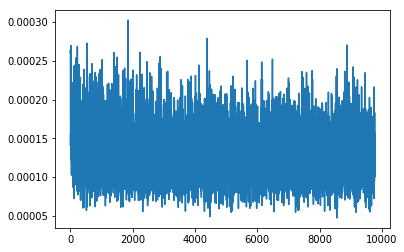

In [64]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()